# Minimal Effort Learning Model

## 1. Initial Set up

In [3]:
import nengo
import numpy as np
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt

First we import the raw data from MT_S2

In [16]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S2"

# Datapath to get the raw data file (Stored in DataExtraction)
datafile_path = "./../../Data Extraction/Extracted Data/MT_S1_raw.csv"      # r"..\\..\\Data Extraction\\Extracted Data\\"+monkey+"_raw.csv"

df = pd.read_csv(datafile_path)

headers = df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)
print(headers)

# getting the activity matrix
neuron_columns = [col for col in df.columns if col.startswith('Neuron')]
activity_matrix = df[neuron_columns]

# velocity data
velocity_matrix = df[["x_velocity", "y_velocity"]]
# acceleration data
acceleration_matrix = df[["x_acceleration", "y_acceleration"]]

# transpose the data
activity_matrix_t = activity_matrix.transpose().to_numpy()
velocity_matrix_t = velocity_matrix.transpose().to_numpy()
acceleration_matrix_t = acceleration_matrix.transpose().to_numpy()

print(df["Timestamp"])

['Unnamed: 0', 'Timestamp', 'Neuron1', 'Neuron2', 'Neuron3', 'Neuron4', 'Neuron5', 'Neuron6', 'Neuron7', 'Neuron8', 'Neuron9', 'Neuron10', 'Neuron11', 'Neuron12', 'Neuron13', 'Neuron14', 'Neuron15', 'Neuron16', 'Neuron17', 'Neuron18', 'Neuron19', 'Neuron20', 'Neuron21', 'Neuron22', 'Neuron23', 'Neuron24', 'Neuron25', 'Neuron26', 'Neuron27', 'Neuron28', 'Neuron29', 'Neuron30', 'Neuron31', 'Neuron32', 'Neuron33', 'Neuron34', 'Neuron35', 'Neuron36', 'Neuron37', 'Neuron38', 'Neuron39', 'Neuron40', 'Neuron41', 'Neuron42', 'Neuron43', 'Neuron44', 'Neuron45', 'Neuron46', 'Neuron47', 'Neuron48', 'Neuron49', 'x_velocity', 'y_velocity', 'x_acceleration', 'y_acceleration']
0           1.000
1           1.001
2           1.002
3           1.003
4           1.004
           ...   
800996    801.996
800997    801.997
800998    801.998
800999    801.999
801000    802.000
Name: Timestamp, Length: 801001, dtype: float64


## 2. Building the model

Setting the model parameters

In [23]:
spikes = activity_matrix_t 
scalar = np.max(spikes)
target_out = acceleration_matrix_t/scalar 

# Model Information
dt = 0.001
dti = 1/dt
spikes = spikes*dti

# Model Parameters
n_ensemble_neurons = 3000
ensemble_radius = 1     # ? Represents the range of values for the neurons?
ensemble_synapse = 0.025
probe_synapse = 0.01

running_time = 300 # How long the model should run for
training_time = 0.8*running_time # WHen does the model stop learning


Building the nengo network

In [ ]:
with nengo.Network() as model:
    in_node = nengo.Node(lambda t: spikes[:,int(t / dt) - 1])
    
    target_node = nengo.Node(lambda t: target_out[:,int(t / dt) - 1]) # expected kinematic output
    inhib_node = nengo.Node(output=lambda t: t >= training_time)

    rep_ens = nengo.Ensemble(n_ensemble_neurons, n_neurons, ensemble_radius)
    out_ens = nengo.Ensemble(n_ensemble_neurons, 2, ensemble_radius)
    err_ens = nengo.Ensemble(n_ensemble_neurons, 2, ensemble_radius)

    in_rep_con = nengo.Connection(in_node, rep_ens, ensemble_synapse) # Acts as a low-pass for the spike input
    rep_out_con = nengo.Connection(rep_ens, out_ens, function=lambda x: [0, 0], learning_rule_type=nengo.PES(learning_rate=2e-4))
    out_err_con = nengo.Connection(out_ens, err_ens)
    tar_err_con = nengo.Connection(target_node, err_ens, transform=-1)
    err_lrn_con = nengo.Connection(err_ens, rep_out_con.learning_rule) # Connects error ensemble value to learning rule -- analogous to how backprop uses error to follow stochastic gradient in training
    inhib_lrn_con = nengo.Connection(inhib_node, err_ens.neurons, transform=-20 * np.ones((err_ens.n_neurons, 1))) # Inhibit error ensemble once training is done to prevent weight changes after training_time

    p_out = nengo.Probe(out_ens, synapse=probe_synapse)
    p_err = nengo.Probe(err_ens, synapse=probe_synapse)




## 3. Visualizing results


In [ ]:
with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(running_time)

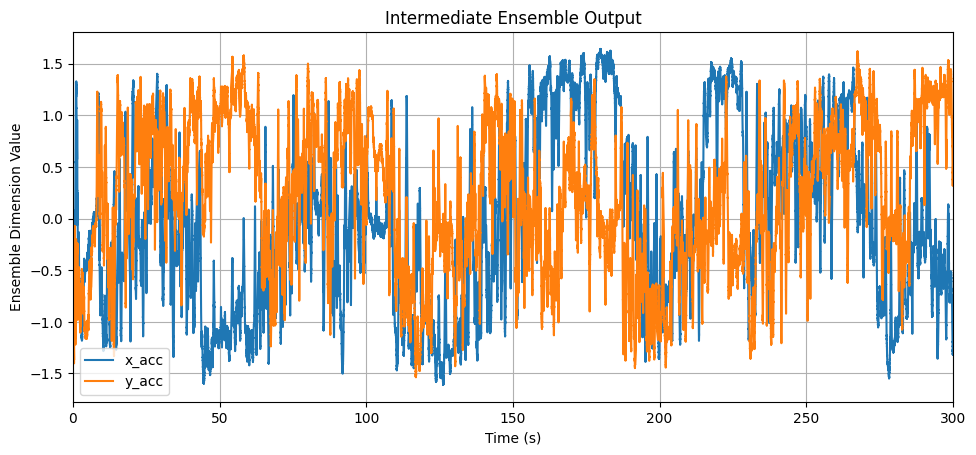

In [32]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_out])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()